In [1]:
# In this notebook along to the tiling I am also going to add the standard augmentation techniques such as rot. / shift.

### Preparing the dataframe 

In [2]:
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt 

In [3]:
# Gdrive shit path
# #/Users/krish/Library/CloudStorage/GoogleDrive-krishthephysicist@gmail.com/My Drive/ljmu/1.data
# root_path =  r'/Users/krish/Library/CloudStorage/GoogleDrive-krishthephysicist@gmail.com/My Drive/ljmu/'
# result_root = root_path + '3.results/06112022-tiling+augmentation/'
# Path(result_root).mkdir(parents=True, exist_ok=True)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%d%m%Y-%H%M")

In [5]:
# Mac local path
root_path =  r'/Users/krish/ljmu/'
result_root = root_path + '3.results/10112022-tiling+augmentation-afo/'
Path(result_root).mkdir(parents=True, exist_ok=True)

In [6]:
df_true = pd.DataFrame(columns = ['name','flag'])
df_false = pd.DataFrame(columns = ['name','flag'])

df_true['name'] = glob.glob(root_path+'1.data/afo/tiled/ts/*.jpg')
df_true.flag = 1

df_false['name'] = glob.glob(root_path+'1.data/afo/tiled/false/*.jpg')
df_false.flag = 0

df = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_4363/1368382229.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_true.append(df_false)


In [7]:
df_true.shape

(17953, 2)

In [8]:
df_false.shape

(44450, 2)

In [9]:
df

,name,flag
0,/Users/krish/ljmu/1.data/afo/tiled/ts/a_1178_1...,1
1,/Users/krish/ljmu/1.data/afo/tiled/ts/k4_184_0...,1
2,/Users/krish/ljmu/1.data/afo/tiled/ts/b1_211_2...,1
3,/Users/krish/ljmu/1.data/afo/tiled/ts/r4_109_1...,1
4,/Users/krish/ljmu/1.data/afo/tiled/ts/e_47_2_3...,1
...,...,...
44445,/Users/krish/ljmu/1.data/afo/tiled/false/a_357...,0
44446,/Users/krish/ljmu/1.data/afo/tiled/false/w1_29...,0
44447,/Users/krish/ljmu/1.data/afo/tiled/false/a_106...,0
44448,/Users/krish/ljmu/1.data/afo/tiled/false/b1_16...,0


In [10]:
import os
os.getcwd()
glob.glob("")

[]

### Training as before

In [11]:
#!pip install skimage

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [13]:
#!pip install scikit-image

In [14]:
#!pip install tensorflow

In [15]:
df['flag'] = df.flag.apply(lambda x: str(x)) # used the qubit format

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
#!pip install sklearn

In [18]:
train_df, valid_df = train_test_split(df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = df['flag']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 46802 validation 15601


In [18]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [19]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)

Found 5317 validated image filenames belonging to 2 classes.
Found 1773 validated image filenames belonging to 2 classes.


### Bring in the model

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [30]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer
# (224,224,3) is the default shape for imagent and that actually cant bechanged
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

Metal device set to: Apple M1


2022-11-07 17:22:45.945145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-07 17:22:45.945475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
#             loss='categorical_crossentropy',
#             metrics = ['accuracy'])

# model.summary()

In [32]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              5

In [33]:
class_weight = {0:1.,1:1.5}
history = model.fit(train_generator, validation_data = valid_generator, epochs = 20, class_weight=class_weight)

Epoch 1/20


2022-11-07 17:22:47.068574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-07 17:22:48.085224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.4553

2022-11-07 17:24:45.458290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 132s 773ms/step - loss: 0.8224 - accuracy: 0.4553 - val_loss: 0.6811 - val_accuracy: 0.4738
Epoch 2/20
167/167 [==============================] - 138s 827ms/step - loss: 0.7825 - accuracy: 0.5112 - val_loss: 0.6364 - val_accuracy: 0.6142
Epoch 3/20
167/167 [==============================] - 91s 542ms/step - loss: 0.7221 - accuracy: 0.6468 - val_loss: 0.5719 - val_accuracy: 0.7039
Epoch 4/20
167/167 [==============================] - 77s 460ms/step - loss: 0.6389 - accuracy: 0.7470 - val_loss: 0.4923 - val_accuracy: 0.7862
Epoch 5/20
167/167 [==============================] - 76s 453ms/step - loss: 0.5440 - accuracy: 0.8119 - val_loss: 0.4065 - val_accuracy: 0.8347
Epoch 6/20
167/167 [==============================] - 78s 466ms/step - loss: 0.4576 - accuracy: 0.8458 - val_loss: 0.3515 - val_accuracy: 0.8607
Epoch 7/20
167/167 [==============================] - 77s 459ms/step - loss: 0.4039 - accuracy: 0.8650 - val_loss: 0.3153 - val_accuracy: 0

In [34]:
model.save(result_root+'mobilenet_after_tiling_20epochs')

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/06112022-tiling+augmentation/mobilenet_after_tiling_10epochs/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/06112022-tiling+augmentation/mobilenet_after_tiling_10epochs/assets


In [35]:
from tensorflow import keras
model = keras.models.load_model(result_root+'mobilenet_after_tiling_20epochs')

2022-11-07 17:51:18.347117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 - 7s - loss: 0.2448 - accuracy: 0.9052 - 7s/epoch - 131ms/step


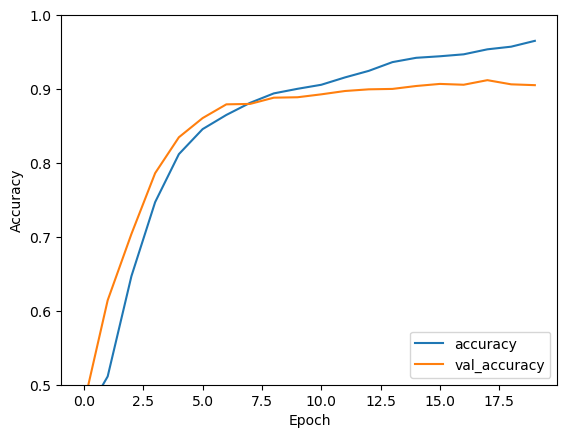

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_generator, verbose=2)

plt.savefig(result_root+'accuracy_after_tiling.png')

In [37]:
# Spoke with sharma, this validation is basically the test score, as it does not feedback into the model training phase.
# class_weight = {0:1.,1:2.}
# history = model.fit(train_generator, epochs = 6, class_weight=class_weight)

## Adding other augmentation techniques

In [33]:
# https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

In [34]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [36]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)

Found 46802 validated image filenames belonging to 2 classes.
Found 15601 validated image filenames belonging to 2 classes.


In [37]:
# i'll be using inception_v3 for this model2 , along with 2 extra dense layers and the output layer
# (224,224,3) is the default shape for imagent and that actually cant bechanged
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model2 = Sequential()
model2.add(mobilenet)
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))

model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))

model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))



model2.add(Dense(1, activation="sigmoid" , name="classification"))

In [38]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dense_14 (Dense)            (None, 1024)             

In [39]:
class_weight = {0:1.,1:1.5}
history2 = model2.fit(train_generator, validation_data = valid_generator, epochs = 10, class_weight=class_weight)

Epoch 1/10


2022-11-10 22:43:15.202237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1463/1463 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8457

2022-11-10 22:55:44.756296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1463/1463 [==============================] - 883s 602ms/step - loss: 0.4815 - accuracy: 0.8457 - val_loss: 0.2508 - val_accuracy: 0.9143
Epoch 2/10
1463/1463 [==============================] - 6244s 4s/step - loss: 0.3000 - accuracy: 0.9156 - val_loss: 0.2050 - val_accuracy: 0.9305
Epoch 3/10
1463/1463 [==============================] - 5453s 4s/step - loss: 0.2785 - accuracy: 0.9231 - val_loss: 0.1977 - val_accuracy: 0.9349
Epoch 4/10
1463/1463 [==============================] - 4447s 3s/step - loss: 0.2632 - accuracy: 0.9275 - val_loss: 0.1896 - val_accuracy: 0.9369
Epoch 5/10
1463/1463 [==============================] - 883s 603ms/step - loss: 0.2552 - accuracy: 0.9303 - val_loss: 0.1835 - val_accuracy: 0.9378
Epoch 6/10
1463/1463 [==============================] - 762s 521ms/step - loss: 0.2472 - accuracy: 0.9326 - val_loss: 0.1786 - val_accuracy: 0.9389
Epoch 7/10
1463/1463 [==============================] - 774s 529ms/step - loss: 0.2391 - accuracy: 0.9347 - val_loss: 0.1721 - va

In [40]:
model2.save(result_root+date_time+'mobilenet_after_tiling+augmentations_20epochs')

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/10112022-tiling+augmentation-afo/10112022-1917mobilenet_after_tiling+augmentations_20epochs/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/10112022-tiling+augmentation-afo/10112022-1917mobilenet_after_tiling+augmentations_20epochs/assets


488/488 - 138s - loss: 0.1631 - accuracy: 0.9434 - 138s/epoch - 282ms/step


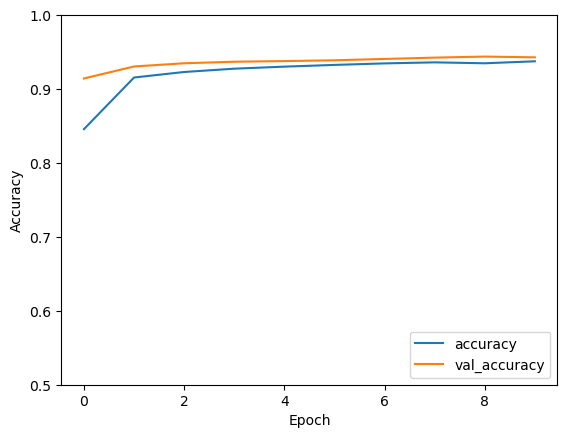

In [41]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model2.evaluate(valid_generator, verbose=2)

plt.savefig(result_root+date_time+'accuracy_after_tiling+augmnetaion_20epochs.png')

In [42]:
print(test_acc)

0.9434010982513428
